In [4]:
import os
os.chdir('/homes/pr450/repos/research_projects/sampling_ddpm')

os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch

from tqdm import tqdm
from torch import Tensor as _T

from ddpm.model.main.multiepoch import MultiPreparatoryHVAEReverseProcess

from ddpm.utils.loading import generate_model_and_task_from_args_path_multiepoch
from purias_utils.util.logging import configure_logging_paths
from purias_utils.util.plotting import standard_swap_model_simplex_plots
from purias_utils.error_modelling_torus.non_parametric_error_model.setup_utils import setup_model_whole

from purias_utils.multiitem_working_memory.util.circle_utils import rectify_angles, polar2cart

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cmx
import matplotlib.colors as colors

from analysis.new_analysis.plane_alignment_utils import *


import numpy as np
from scipy.spatial.distance import pdist

In [5]:

base_dir_name = 'hvae_with_dendritic_20250410'

device = 'cuda'


# # run_name = 'run_a2_probe_cued_rnn_no_swap_1'
# # run_name = 'run_a3_probe_cued_diffusion_no_swap_1'
# # run_name = 'run_a4_probe_cued_diffusion_flat_swap_1'
# # run_name = 'run_a5_probe_cued_diffusion_cyclical_swap_1'
# # run_name = 'run_a6_probe_cued_diffusion_sharp_swap_2'


#run_name = 'run_a3_probe_cued_diffusion_no_swap_1'
#run_name = 'run_a4b_probe_cued_diffusion_flat_less_swap_0'
#run_name = 'run_a4c_probe_cued_diffusion_flat_even_less_swap_0'
#run_name = 'run_a5b_probe_cued_diffusion_cyclical_less_swap_0'
run_name = 'run_a5b_probe_cued_diffusion_cyclical_less_swap_1'
#run_name = 'run_a5c_probe_cued_diffusion_cyclical_less_swap_more_0'
#run_name = 'run_a5c_probe_cued_diffusion_cyclical_less_swap_more_1'

#run_name = 'run_c2_index_cued_diffusion_no_swap_1'
#run_name = 'run_c3_index_cued_diffusion_0.05_swap_0'
#run_name = 'run_c3_index_cued_diffusion_0.1_swap_0'




_, task, ddpm_model, _, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/args.yaml', device)
ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/state.mdl', weights_only=True))
ddpm_model: MultiPreparatoryHVAEReverseProcess


for n, parameter in ddpm_model.named_parameters():
    parameter.required_grad = False


Initialising generative_model after 0 failed attempts at stability...


  0%|          | 0/10000 [00:00<?, ?it/s]

Fix simplex_plots to handle >1 models at the same time!, i.e. Q axis exists...


  0%|          | 45/10000 [00:11<42:00,  3.95it/s] 
/homes/pr450/repos/all_utils/purias_utils/error_modelling_torus/non_parametric_error_model/main.py:356: SyntaxWarning: invalid escape sequence '\p'
  axes_logits.scatter(q_axis, pi_u_tildes, marker='s', label = '$\\tilde{\pi}_u$')
/homes/pr450/repos/all_utils/purias_utils/error_modelling_torus/non_parametric_error_model/main.py:358: SyntaxWarning: invalid escape sequence '\p'
  axes_logits.scatter(q_axis, pi_1_tildes, marker='s', label = '$\\tilde{\pi}_1$')
/homes/pr450/repos/all_utils/purias_utils/error_modelling_torus/non_parametric_error_model/main.py:363: SyntaxWarning: invalid escape sequence '\p'
  swap_color = axes_logits.plot(q_axis, logit_means, marker='x', linestyle='none', label = '$\\tilde{\pi}_{swap}$')[0].get_color()


KeyboardInterrupt: 

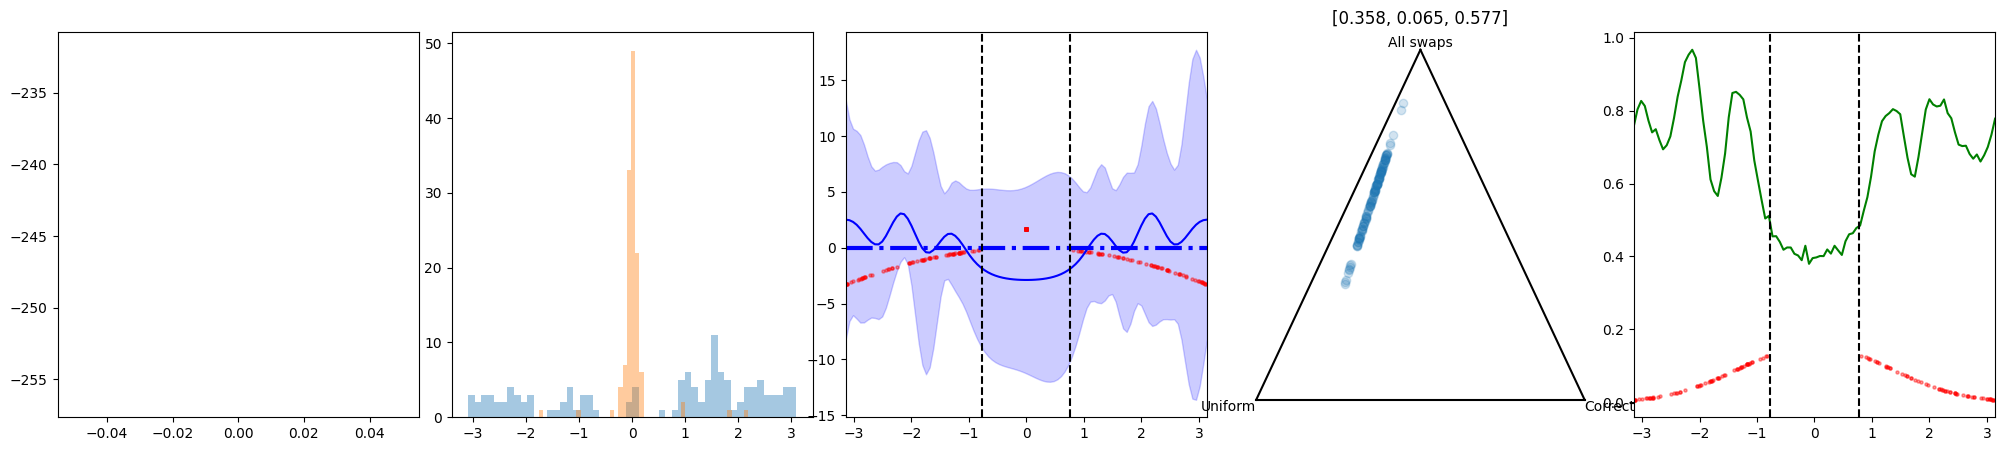

In [6]:
save_path = f'results_link_sampler/analysis/bns_fits_final/{run_name}'
try:
    os.mkdir(save_path)
except FileExistsError:
    pass


device = 'cuda'

emission_type = 'von_mises'
kernel_type = 'weiland'
trainable_kernel_delta = False
normalisation_inner = 'exp'
inducing_point_variational_parameterisation_type = 'gaussian'
init_min_seps = False
all_set_sizes = [2]
R_per_dim = 12
fix_inducing_point_locations = False
fix_non_swap = True
include_pi_1_tilde = False
#include_pi_u_tilde = False                      # XXX
#remove_uniform = True                           # XXX
include_pi_u_tilde = True
remove_uniform = False
monte_carlo_gp_samples = 1024
resume_path = None
shared_emission_distribution = False
shared_swap_function = False
swap_type = 'cue_dim_only'
symmetricality_constraint = True

min_sep = torch.pi / task.task_variable_gen.min_sep

num_models = 1


swap_model, D, delta_dimensions = setup_model_whole(
    num_models = num_models,
    swap_type = swap_type,
    kernel_type = kernel_type,
    emission_type = emission_type,
    all_set_sizes = all_set_sizes,
    remove_uniform = remove_uniform,
    include_pi_u_tilde = include_pi_u_tilde,
    trainable_kernel_delta = trainable_kernel_delta,
    R_per_dim = R_per_dim,
    fix_non_swap = fix_non_swap,
    include_pi_1_tilde = include_pi_1_tilde,
    fix_inducing_point_locations = fix_inducing_point_locations,
    symmetricality_constraint = symmetricality_constraint,
    shared_swap_function = shared_swap_function,
    shared_emission_distribution = shared_emission_distribution,
    all_min_seps = torch.tensor([[min_sep, min_sep]]),
    inducing_point_variational_parameterisation_type=inducing_point_variational_parameterisation_type,
    normalisation_inner= normalisation_inner,
    num_variational_samples = monte_carlo_gp_samples,
    num_importance_sampling_samples = monte_carlo_gp_samples,
    device=device,
    resume_path = None,
)


try:
    swap_model.generative_model.swap_function.fixed_pi_1_tilde = task.task_variable_gen.swap_function_offset
except AttributeError:
    swap_model.generative_model.swap_function.fixed_pi_1_tilde = 0.0


# swap_model.generative_model.swap_function._fixed_pi_1_tilde


batch_size = 128
num_samples = 1
flip_augmentation = True

opt = torch.optim.Adam(swap_model.parameters(), lr = 0.01)

swap_model.cuda()

all_llh = []


infinite_data_mode = True


for i in tqdm(range(10_000)):

    if infinite_data_mode or i == 0:

        trial_information = task.generate_trial_information(batch_size=batch_size, num_samples=num_samples)

        with torch.no_grad():
            novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
                # prep_network_inputs=[
                #     pni[[0]] for pni in trial_information.prep_network_inputs
                # ],
                # diffusion_network_inputs=[
                #     dni[[0]] for dni in trial_information.diffusion_network_inputs
                # ],
                prep_network_inputs = trial_information.prep_network_inputs,
                diffusion_network_inputs = trial_information.diffusion_network_inputs,
                prep_epoch_durations=trial_information.prep_epoch_durations,
                diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
                samples_shape=[batch_size, num_samples],
                noise_scaler=1.0,
            )


        cued_idx = trial_information.task_variable_information['cued_item_idx']

        all_probe_values = rectify_angles(trial_information.task_variable_information['probe_features'])
        probe_values = torch.zeros_like(all_probe_values)
        probe_values[torch.arange(batch_size),0] = all_probe_values[torch.arange(batch_size),cued_idx]
        probe_values[torch.arange(batch_size),1] = all_probe_values[torch.arange(batch_size),1-cued_idx]
        probe_deltas = rectify_angles(probe_values - probe_values[:,[0]])
        deltas_batch = probe_deltas.unsqueeze(-1).unsqueeze(0).repeat_interleave(num_models, 0)

        all_report_values = rectify_angles(trial_information.task_variable_information['report_features'])
        report_values = torch.zeros_like(all_report_values)
        report_values[torch.arange(batch_size),0] = all_report_values[torch.arange(batch_size),cued_idx]
        report_values[torch.arange(batch_size),1] = all_report_values[torch.arange(batch_size),1-cued_idx]

        responses_cart = novel_samples_dict['samples'].squeeze(1)
        responses = torch.arctan2(responses_cart[:,1], responses_cart[:,0]).unsqueeze(-1)

        errors = rectify_angles(responses - report_values)
        errors_batch = errors.unsqueeze(0).repeat_interleave(num_models, 0)


    if flip_augmentation:
        augmentation_map_deltas = (2 * (torch.rand_like(deltas_batch) < 0.5).int()) - 1
        deltas_batch = deltas_batch * augmentation_map_deltas.to(dtype = deltas_batch.dtype, device = deltas_batch.device)

        augmentation_map_errors = (2 * (torch.rand_like(errors_batch) < 0.5).int()) - 1
        errors_batch = errors_batch * augmentation_map_errors.to(dtype = errors_batch.dtype, device = deltas_batch.device)

    training_info = swap_model.get_elbo_terms(deltas = deltas_batch.cuda(), data = errors_batch.cuda(), max_variational_batch_size = 64)

    opt.zero_grad()

    selected_beta = 0.1
    total_elbo = (training_info['total_log_likelihood'] - selected_beta * training_info['kl_term'])
    total_loss = - total_elbo

    total_loss.sum().backward()
    opt.step()

    all_llh.append(training_info['total_log_likelihood'].item())

    torch.cuda.empty_cache()

    if i % 100 == 0:

        plt.close('all')

        fig, axes = plt.subplot_mosaic(
            '''
            AABBCCDDEE
            AABBCCDDEE
            ''', figsize = (25, 5)
        )

        axes['A'].plot(all_llh)

        cued_idx = trial_information.task_variable_information['cued_item_idx']
        all_probe_values = rectify_angles(trial_information.task_variable_information['probe_features'])
        probe_values = torch.zeros_like(all_probe_values)
        probe_values[torch.arange(batch_size),0] = all_probe_values[torch.arange(batch_size),cued_idx]
        probe_values[torch.arange(batch_size),1] = all_probe_values[torch.arange(batch_size),1-cued_idx]
        probe_deltas = rectify_angles(probe_values - probe_values[:,[0]])
        deltas_batch = probe_deltas.unsqueeze(-1).unsqueeze(0).repeat_interleave(num_models, 0)
        all_report_values = rectify_angles(trial_information.task_variable_information['report_features'])
        report_values = torch.zeros_like(all_report_values)
        report_values[torch.arange(batch_size),0] = all_report_values[torch.arange(batch_size),cued_idx]
        report_values[torch.arange(batch_size),1] = all_report_values[torch.arange(batch_size),1-cued_idx]
        responses_cart = novel_samples_dict['samples'].squeeze(1)
        responses = torch.arctan2(responses_cart[:,1], responses_cart[:,0]).unsqueeze(-1)
        errors = rectify_angles(responses - report_values)
        errors_batch = errors.unsqueeze(0).repeat_interleave(num_models, 0)
        axes['B'].hist(errors[:,1], 50, alpha = 0.4)
        axes['B'].hist(errors[:,0], 50, alpha = 0.4)


        inference_info = swap_model.inference_on_grid(set_size=2, grid_count=100)
        one_dimensional_grid = inference_info['one_dimensional_grid']
        all_grid_points = inference_info['all_grid_points']
        mean_surface = inference_info['mean_surface']
        std_surface = inference_info['std_surface']
        function_samples_on_grid = inference_info['function_samples_on_grid']

        q = 0
        qth_mean_surface = mean_surface[q]
        qth_lower_surface, qth_upper_surface = qth_mean_surface - 2 * std_surface[q], qth_mean_surface + 2 * std_surface[q]

        surface_color = 'blue'

        axes['C'].plot(one_dimensional_grid, qth_mean_surface, color = 'blue')[0].get_color()
        axes['C'].fill_between(one_dimensional_grid, qth_lower_surface, qth_upper_surface, color = surface_color, alpha = 0.2)

        if not remove_uniform:
            display_pi_u_tilde = swap_model.generative_model.swap_function.pi_u_tilde_holder['2'].pi_tilde.detach().cpu()
            axes['C'].plot([-torch.pi, torch.pi], [display_pi_u_tilde[q].item(), display_pi_u_tilde[q].item()], surface_color, linestyle= '-.', linewidth = 3)

        y_bot, y_top = axes['C'].get_ylim()
        sep = torch.pi/4.1
        axes['C'].plot([sep, sep], [y_bot, y_top], color = 'black', linestyle = '--')
        axes['C'].plot([-sep, -sep], [y_bot, y_top], color = 'black', linestyle = '--')
        axes['C'].set_ylim(y_bot, y_top)
        axes['C'].set_xlim(-torch.pi, torch.pi)

        distractor_f_samples = mean_surface + std_surface * np.random.randn(1000, std_surface.shape[1])
        distractor_swap_samples = np.exp(distractor_f_samples) / (np.exp(swap_model.generative_model.swap_function.fixed_pi_1_tilde) + np.exp(distractor_f_samples))
        distractor_swap_samples_avg = distractor_swap_samples.mean(0)
        axes['E'].plot(one_dimensional_grid, distractor_swap_samples_avg, color = 'green')

        axes['E'].scatter(deltas_batch[0,range(batch_size),1,0], trial_information.task_variable_information['swap_probabilities'][range(batch_size), 1-cued_idx], color = 'red', alpha = 0.4, s = 5)
        #axes['E'].scatter(deltas_batch[0].flatten(), true_swap_function.softmax(-1).flatten(), color = 'red', alpha = 0.4, s = 5)
        #axes['E'].plot([-torch.pi, torch.pi], [display_pi_u_tilde[q].item(), display_pi_u_tilde[q].item()], surface_color, linestyle= '-.', linewidth = 3)

        y_bot, y_top = axes['E'].get_ylim()
        sep = torch.pi/4.1
        axes['E'].plot([sep, sep], [y_bot, y_top], color = 'black', linestyle = '--')
        axes['E'].plot([-sep, -sep], [y_bot, y_top], color = 'black', linestyle = '--')
        axes['E'].set_ylim(y_bot, y_top)
        axes['E'].set_xlim(-torch.pi, torch.pi)

        if 'swap_func' in trial_information.task_variable_information:
            # true_swap_func = -0.5 * (deltas_batch.square() / (2.0 + 2e-5))
            all_true_swap_function = trial_information.task_variable_information['swap_func']
            
            true_swap_function = torch.zeros_like(all_probe_values)
            true_swap_function[torch.arange(batch_size),0] = all_true_swap_function[torch.arange(batch_size),cued_idx]
            true_swap_function[torch.arange(batch_size),1] = all_true_swap_function[torch.arange(batch_size),1-cued_idx]
            axes['C'].scatter(deltas_batch[0].flatten(), true_swap_function.flatten(), color = 'red', alpha = 0.4, s = 5)


        standard_swap_model_simplex_plots(training_info['priors'][0].detach().cpu().numpy(), axes['D'])
        axes['D'].set_title(training_info['priors'][0].mean(0).round(decimals = 3).tolist())

        fig.savefig(os.path.join(save_path, 'fit'))
        torch.save(swap_model.state_dict(), os.path.join(save_path, 'swap_model.mdl'))


In [17]:
load_runpath = 'run_a5_probe_cued_diffusion_cyclical_swap_0'


swap_model.load_state_dict(torch.load(os.path.join(save_path, 'swap_model.mdl')))


fig, axes = plt.subplot_mosaic(
    '''
    AABBCCDDEE
    AABBCCDDEE
    ''', figsize = (25, 5)
)

axes['A'].plot(all_llh)

cued_idx = trial_information.task_variable_information['cued_item_idx']
all_probe_values = rectify_angles(trial_information.task_variable_information['probe_features'])
probe_values = torch.zeros_like(all_probe_values)
probe_values[torch.arange(batch_size),0] = all_probe_values[torch.arange(batch_size),cued_idx]
probe_values[torch.arange(batch_size),1] = all_probe_values[torch.arange(batch_size),1-cued_idx]
probe_deltas = rectify_angles(probe_values - probe_values[:,[0]])
deltas_batch = probe_deltas.unsqueeze(-1).unsqueeze(0).repeat_interleave(num_models, 0)
all_report_values = rectify_angles(trial_information.task_variable_information['report_features'])
report_values = torch.zeros_like(all_report_values)
report_values[torch.arange(batch_size),0] = all_report_values[torch.arange(batch_size),cued_idx]
report_values[torch.arange(batch_size),1] = all_report_values[torch.arange(batch_size),1-cued_idx]
responses_cart = novel_samples_dict['samples'].squeeze(1)
responses = torch.arctan2(responses_cart[:,1], responses_cart[:,0]).unsqueeze(-1)
errors = rectify_angles(responses - report_values)
errors_batch = errors.unsqueeze(0).repeat_interleave(num_models, 0)
axes['B'].hist(errors[:,1], 50, alpha = 0.4)
axes['B'].hist(errors[:,0], 50, alpha = 0.4)


inference_info = swap_model.inference_on_grid(set_size=2, grid_count=100)
one_dimensional_grid = inference_info['one_dimensional_grid']
all_grid_points = inference_info['all_grid_points']
mean_surface = inference_info['mean_surface']
std_surface = inference_info['std_surface']
function_samples_on_grid = inference_info['function_samples_on_grid']

q = 0
qth_mean_surface = mean_surface[q]
qth_lower_surface, qth_upper_surface = qth_mean_surface - 2 * std_surface[q], qth_mean_surface + 2 * std_surface[q]

display_pi_u_tilde = swap_model.generative_model.swap_function.pi_u_tilde_holder['2'].pi_tilde.detach().cpu()

surface_color = 'blue'

axes['C'].plot(one_dimensional_grid, qth_mean_surface, color = 'blue')[0].get_color()
axes['C'].fill_between(one_dimensional_grid, qth_lower_surface, qth_upper_surface, color = surface_color, alpha = 0.2)
axes['C'].plot([-torch.pi, torch.pi], [display_pi_u_tilde[q].item(), display_pi_u_tilde[q].item()], surface_color, linestyle= '-.', linewidth = 3)

y_bot, y_top = axes['C'].get_ylim()
sep = torch.pi/4.1
axes['C'].plot([sep, sep], [y_bot, y_top], color = 'black', linestyle = '--')
axes['C'].plot([-sep, -sep], [y_bot, y_top], color = 'black', linestyle = '--')
axes['C'].set_ylim(y_bot, y_top)
axes['C'].set_xlim(-torch.pi, torch.pi)

distractor_f_samples = mean_surface + std_surface * np.random.randn(1000, std_surface.shape[1])
distractor_swap_samples = np.exp(distractor_f_samples) / (np.exp(swap_model.generative_model.swap_function.fixed_pi_1_tilde) + np.exp(distractor_f_samples))
distractor_swap_samples_avg = distractor_swap_samples.mean(0)
axes['E'].plot(one_dimensional_grid, distractor_swap_samples_avg, color = 'green')

axes['E'].scatter(deltas_batch[0,range(batch_size),1,0], trial_information.task_variable_information['swap_probabilities'][range(batch_size), 1-cued_idx], color = 'red', alpha = 0.4, s = 5)
#axes['E'].scatter(deltas_batch[0].flatten(), true_swap_function.softmax(-1).flatten(), color = 'red', alpha = 0.4, s = 5)
#axes['E'].plot([-torch.pi, torch.pi], [display_pi_u_tilde[q].item(), display_pi_u_tilde[q].item()], surface_color, linestyle= '-.', linewidth = 3)

y_bot, y_top = axes['E'].get_ylim()
sep = torch.pi/4.1
axes['E'].plot([sep, sep], [y_bot, y_top], color = 'black', linestyle = '--')
axes['E'].plot([-sep, -sep], [y_bot, y_top], color = 'black', linestyle = '--')
axes['E'].set_ylim(y_bot, y_top)
axes['E'].set_xlim(-torch.pi, torch.pi)

if 'swap_func' in trial_information.task_variable_information:
    # true_swap_func = -0.5 * (deltas_batch.square() / (2.0 + 2e-5))
    all_true_swap_function = trial_information.task_variable_information['swap_func']
    
    true_swap_function = torch.zeros_like(all_probe_values)
    true_swap_function[torch.arange(batch_size),0] = all_true_swap_function[torch.arange(batch_size),cued_idx]
    true_swap_function[torch.arange(batch_size),1] = all_true_swap_function[torch.arange(batch_size),1-cued_idx]
    axes['C'].scatter(deltas_batch[0].flatten(), true_swap_function.flatten(), color = 'red', alpha = 0.4, s = 5)

standard_swap_model_simplex_plots(training_info['priors'][0].detach().cpu().numpy(), axes['D'])
axes['D'].set_title(training_info['priors'][0].mean(0).round(decimals = 3).tolist())

fig.savefig(os.path.join(save_path, 'fit'))
torch.save(swap_model.state_dict(), os.path.join(save_path, 'swap_model.mdl'))


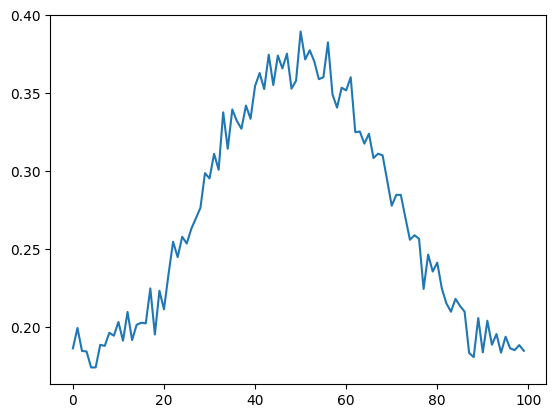

In [46]:
plt.plot(distractor_swap_samples_avg)

## Not fitting - just getting empirical swap rates

In [4]:

base_dir_name = 'hvae_with_dendritic_20250410'

device = 'cuda'


# # run_name = 'run_a2_probe_cued_rnn_no_swap_1'
# # run_name = 'run_a3_probe_cued_diffusion_no_swap_1'
# # run_name = 'run_a4_probe_cued_diffusion_flat_swap_1'
# # run_name = 'run_a5_probe_cued_diffusion_cyclical_swap_0'
# # run_name = 'run_a6_probe_cued_diffusion_sharp_swap_2'


#run_name = 'run_a3_probe_cued_diffusion_no_swap_1'
#run_name = 'run_a4b_probe_cued_diffusion_flat_less_swap_0'
#run_name = 'run_a4c_probe_cued_diffusion_flat_even_less_swap_0'
run_name = 'run_a5b_probe_cued_diffusion_cyclical_less_swap_0'
#run_name = 'run_a5c_probe_cued_diffusion_cyclical_less_swap_more_0'

#run_name = 'run_c2_index_cued_diffusion_no_swap_1'
#run_name = 'run_c3_index_cued_diffusion_0.05_swap_0'
#run_name = 'run_c3_index_cued_diffusion_0.1_swap_0'




_, task, ddpm_model, _, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/args.yaml', device)
ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/state.mdl', weights_only=True))
ddpm_model: MultiPreparatoryHVAEReverseProcess


for n, parameter in ddpm_model.named_parameters():
    parameter.required_grad = False




trial_information = task.generate_trial_information(batch_size=1024, num_samples=32)

with torch.no_grad():
    novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
        # prep_network_inputs=[
        #     pni[[0]] for pni in trial_information.prep_network_inputs
        # ],
        # diffusion_network_inputs=[
        #     dni[[0]] for dni in trial_information.diffusion_network_inputs
        # ],
        prep_network_inputs = trial_information.prep_network_inputs,
        diffusion_network_inputs = trial_information.diffusion_network_inputs,
        prep_epoch_durations=trial_information.prep_epoch_durations,
        diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
        samples_shape=[1024, 32],
        noise_scaler=1.0,
    )

trial_information.task_variable_information.keys(), novel_samples_dict.keys()

(dict_keys(['probe_features', 'report_features', 'probe_features_cart', 'report_features_cart', 'swap_func', 'swap_probabilities', 'cued_item_idx', 'prep_epoch_durations', 'diffusion_epoch_durations']),
 dict_keys(['end_state', 'sample_trajectory', 'embedded_sample_trajectory', 'samples', 'early_x0_preds', 'epsilon_hat']))

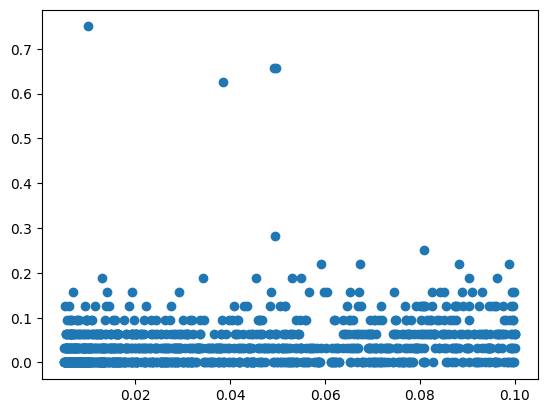

In [5]:
all_report_cart = trial_information.task_variable_information['report_features_cart'] * task.sample_gen.sample_radius
all_target_swap_probs = trial_information.task_variable_information['swap_probabilities']
all_cued_idxs = trial_information.task_variable_information['cued_item_idx']

all_final_samples = novel_samples_dict['samples']
#all_final_samples = all_report_cart[range(1024),all_cued_idxs].unsqueeze(1)

distance_to_correct = (all_final_samples - all_report_cart[range(1024),all_cued_idxs].unsqueeze(1)).square().sum(-1).sqrt()
distance_to_swap = (all_final_samples - all_report_cart[range(1024),1 - all_cued_idxs].unsqueeze(1)).square().sum(-1).sqrt()

swap_happened = torch.where(distance_to_correct > distance_to_swap, 1.0, 0.0)
empirical_swap_prob = swap_happened.mean(1)

plt.scatter(all_target_swap_probs[range(1024),1 - all_cued_idxs].numpy(), empirical_swap_prob.numpy())

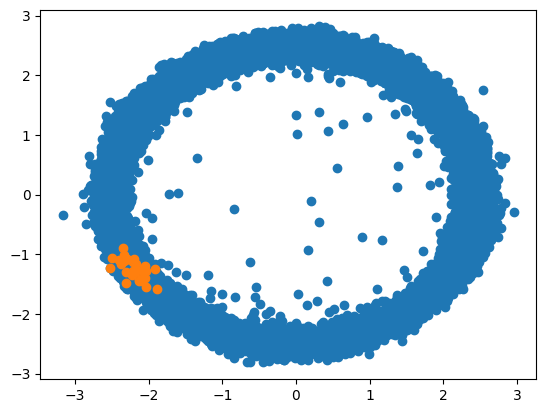

In [94]:
plt.scatter(*all_final_samples.reshape(-1, 2).T)
plt.scatter(*all_final_samples[0,:,:].T)

In [83]:
swap_happened.shape

torch.Size([1024, 32, 2])

In [71]:
all_target_swap_probs

tensor([[0.9690, 0.0310],
        [0.0097, 0.9903],
        [0.9001, 0.0999],
        ...,
        [0.9758, 0.0242],
        [0.0567, 0.9433],
        [0.9901, 0.0099]])